# A study of a simple parabolic motion

This python notebook will explore how python and its various tools (NumPy, SciPy, Matplotlib, etc) can be used to study physics problems, using a very simple and well known example: the parabolic motion.

First of all, let's include some modules:

In [95]:
%matplotlib inline
# the above line just lets matplotlib plot directly in the notebook

# import Numpy, for dealing with data arrays
import numpy as np

# import matplotlib, for plotting figures
import matplotlib.pyplot as plt

# import the mathematical library
import math

## Modeling the trajectory

The trajectory equation for the parabolic motion is well known, and it is:

$$
y = x \tan(\theta) - \frac{g}{2 v_0^2 (\cos{\theta})^2} x^2
$$

It is pretty simple to represent it in python:

In [86]:
theta = math.radians(20) # in radians (converted from degrees)
v_0 = 25  # in m/s
g = 9.81  # in m/s**2

x = np.arange(0, 10, 0.1)  # array of x coordinates in meters
# the trajectory equation
y = x * math.tan(theta) - (g / (2 * v_0**2 * math.cos(theta)**2)) * x**2

To plot it, we create a figure with a certain size, plot `x` and `y`, and also set up some axis labels:

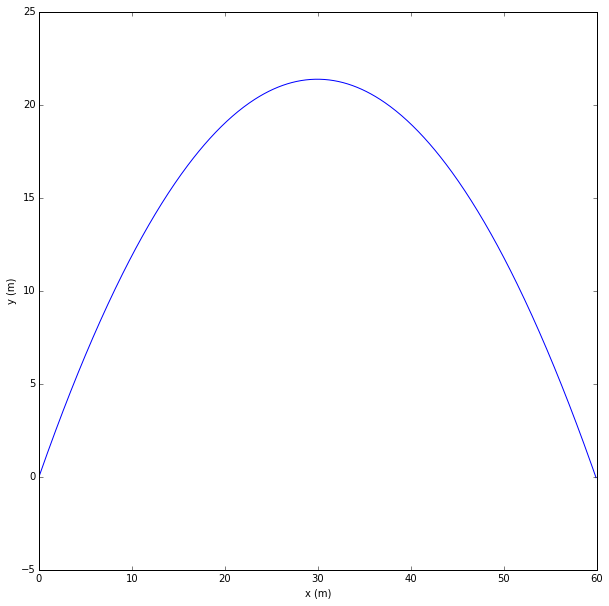

In [96]:
plt.figure(figsize=(10,10))  # the figure
plt.plot(x, y)  # plotting y in function of x
plt.xlabel("x (m)")  # x label
plt.ylabel("y (m)")  # y label
plt.show()  # actually creating the figure

We can plot the trajectory for various values of $\theta$. To do this in an efficienty way, we define a function that returns the parabolic trajectory, taking as inputs the values of $x$, $g$, $v_0$ and $\theta$

In [97]:
def get_y(x, a, v_0, t):
    """
    Simple function to compute y in a parabolic motion
    
    :param x: a numpy array with the X coordinates in meters
    :param a: the acceleration in m/s**2
    :param v_0: the initial velocity in m/s
    :param theta: the initial theta angle in degrees(default=10) 
    """
    
    theta = math.radians(t)
    y = x * math.tan(theta) - (a / (2 * v_0**2 * math.cos(theta)**2)) * x**2
    return y

Then we create a list of values for $\theta$, and plot the various trajectories

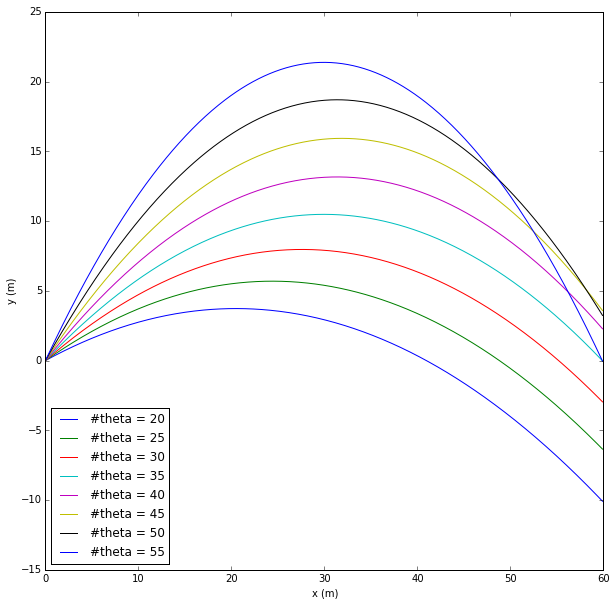

In [99]:
thetas = [t for t in np.arange(20, 60, 5)]
x = np.arange(0, 60, 0.1)  # in meters

plt.figure(figsize=(10, 10))
for t in thetas:
    y = get_y(x, g, v_0, t=t)
    plt.plot(x, y, label="#theta = " + str(t))
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    
plt.legend(loc="best")
plt.show()

## Numerical computation of the maximum range

What if we want to find the $\theta$ value for which we do have the maximum range? In this case, we need to modify our function a bit. If we want to keep it generic (so that we can still set up different accelerations, initial velocities),we need to wrap it up in a `class` (similar to `C++` classes). 

In more details:

* the special `__init__` method is called when you create a new instance of the class, e.g. by doing:
```
f = Parabolic(a, v, t)
```
this is how you pass attributes to the class (in this case, acceleration, initial velocity and the angle)

* the special `__call__` method allows you to use the class instance as a function. In this case, when doing `f(t)` you are calling the method defined in `__call__`, which in this case is simply the trajectory function

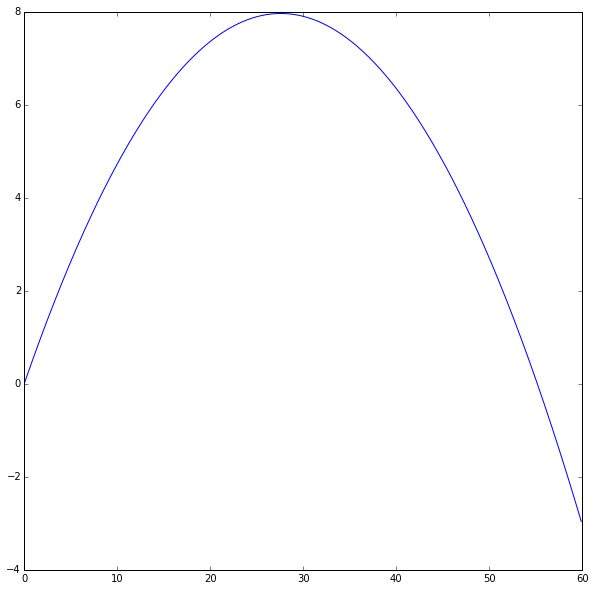

In [102]:
# defining the class
class ParabolicF(object):
    """
    Simple class defining a parabolic trajectory
    """
        
    # the special initialization method:
    def __init__(self, a, v_0, t):
        """
        Setting the parameters for the trajectory function
        """
        self.a = a
        self.v_0 = v_0
        self.t = math.radians(t)
    
    # the method called when the object is called as a function
    def __call__(self, x):
        """
        Returns the y values for a parabolic trajectory, given x
        """
        y = x * math.tan(self.t) - (self.a / (2 * v_0**2 * math.cos(self.t)**2)) * x**2
        return y

# creating an object
f = ParabolicF(g, v_0, 30)
plt.figure(figsize=(10,10))
# using the object as a function
plt.plot(x, f(x))
plt.show()

Why are we doing this? Because we want to use `scipy.optimize.root` to find the roots of our trajectory, and as it is clear from the help, it needs a function as an argument:

In [103]:
from scipy import optimize
help(optimize.root)

Help on function root in module scipy.optimize._root:

root(fun, x0, args=(), method='hybr', jac=None, tol=None, callback=None, options=None)
    Find a root of a vector function.
    
    Parameters
    ----------
    fun : callable
        A vector function to find a root of.
    x0 : ndarray
        Initial guess.
    args : tuple, optional
        Extra arguments passed to the objective function and its Jacobian.
    method : str, optional
        Type of solver.  Should be one of
    
            - 'hybr'
            - 'lm'
            - 'broyden1'
            - 'broyden2'
            - 'anderson'
            - 'linearmixing'
            - 'diagbroyden'
            - 'excitingmixing'
            - 'krylov'
    
    jac : bool or callable, optional
        If `jac` is a Boolean and is True, `fun` is assumed to return the
        value of Jacobian along with the objective function. If False, the
        Jacobian will be estimated numerically.
        `jac` can also be a callable ret

One option would have been to create `N` functions to test `N` values of $\theta$, but this requires a lot of cut & paste and is not very efficient. While, with the class we created, now it's a matter of a simple loop:

In [104]:
results = []  # list that will contain our results

# loop on thetas
for t in thetas:
    f1 = ParabolicF(g, v_0, t)  # creating the object
    root = optimize.root(f1, [0, 1000], method="hybr")  # getting the roots
    results.append(root.x[-1])  # using only the last root, as we know the first one is zero

# printing the maximum value, and the correspondant theta
# np.argmax is a NumPy utility that returns the index of the maximum value
print "Maximum is %.2f meters for theta=%.2f" % (np.max(results), thetas[np.argmax(results)])

Maximum is 63.71 meters for theta=45.00
